#### 如果你想尝试自己的化学图片，可以将图片放在本项目的mol_png文件夹然后在下面第9行代码改成你的图片路径

被识别的原图:


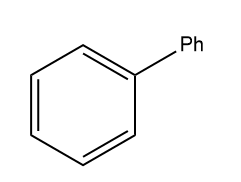


改进前识别结果: C1=CC=C(C=C1)[Pb] 
可视化为：


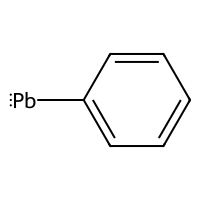


改进后识别结果: C1=CC=C(C=C1)c2ccccc2 
可视化为：


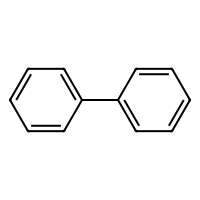

In [19]:
import re
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 强制只用 CPU
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # 可选：减少日志噪音

from DECIMER import predict_SMILES

path = "mol_png/Ph基团2.png"  #可以换成你的图片路径，如"mol_png/长春碱.png"

smiles = predict_SMILES(path)

# ---------- 1. 缩写 → 模板 ----------
ABBR_TEMPLATES = {
    "Ts": "S(=O)(=O)C{r}=CC=C(C)C=C{r}",   # Tosyl
    "Ph": "c{r}ccccc{r}",                  # Phenyl
}

# ---------- 2. 正则预编译 ----------
ABBR_PATTERN = re.compile(r'\[(' + '|'.join(ABBR_TEMPLATES.keys()) + r')\]')
RING_RE      = re.compile(r'%\d{2}|\d')    # 匹配 %10…%99 与 0–9

def _fmt_ring(n: int) -> str:
    return f'%{n:02d}' if n >= 10 else str(n)

# ---------- 3. 主函数 ----------
def expand_abbrev_local(smiles: str) -> str:

    # --- 3-a 预处理：把 Pb 统一纠正为 Ph ---
    smiles = smiles.replace('[Pb]', '[Ph]')

    # --- 3-b 循环替换缩写 ---
    while True:
        m = ABBR_PATTERN.search(smiles)
        if not m:
            break

        abbr = m.group(1)                 
        idx  = m.start()

        rings = RING_RE.findall(smiles[:idx])
        nums  = [int(r[1:]) if r.startswith('%') else int(r) for r in rings]
        new_n = (max(nums) if nums else 0) + 1

        token = _fmt_ring(new_n)
        frag  = ABBR_TEMPLATES[abbr].format(r=token)

        smiles = smiles[:idx] + frag + smiles[m.end():]

    return smiles

# print(f"改进后识别结果: {expand_abbrev_local(smiles)}")

from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import Image, display

mol1 = Chem.MolFromSmiles(smiles)
mol2 = Chem.MolFromSmiles(expand_abbrev_local(smiles))

print("被识别的原图:")
display(Image(filename = path, width=50, height=50))

print("\n改进前识别结果:", smiles, "\n可视化为：")
display(Draw.MolToImage(mol1, size=(200, 200)))

print("\n改进后识别结果:", expand_abbrev_local(smiles),"\n可视化为：")
display(Draw.MolToImage(mol2, size=(200, 200)))


